In [ ]:
!pip install pybullet imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91.7 MB 1.2 MB/s 
     |████████████████████████████████| 26.9 MB 1.4 MB/s 


In [ ]:
import numpy as np
import pybullet as p
import time
import pybullet_data
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML
import gym
from gym import Env, spaces
from math import *
import gym
import numpy as np
import matplotlib.pyplot as plt
import sys
from abc import ABC, abstractmethod
from collections import deque
import random
import math

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable
import torch.optim as optim
from torch.distributions import Normal

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error

In [ ]:
class Replay_Buffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [ ]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

In [ ]:
class RL_algorithm(ABC):

  def reset(self):
    self.episode_reward = 0

  @abstractmethod
  def get_action():
    pass
  
  @abstractmethod
  def update():
    pass
  
  
  def end_episode_update(self, episode_number):
    return self.episode_reward



In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z)
        log_prob = Normal(mean, std).log_prob(mean+ std*z) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state)#.unsqueeze(0)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu() #detach().cpu().numpy()
        return action[0]

In [ ]:
class SAC(RL_algorithm):
  def __init__(self, num_actions, num_states, load = False):
    self.hidden_size = 256
    self.value_net = ValueNetwork(num_states, self.hidden_size)
    self.target_value_net = ValueNetwork(num_states, self.hidden_size)
    self.soft_q_net1 = SoftQNetwork(num_states, num_actions, self.hidden_size)
    self.soft_q_net2 = SoftQNetwork(num_states, num_actions, self.hidden_size)
    self.policy_net = PolicyNetwork(num_states, num_actions, self.hidden_size)

    for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
      target_param.data.copy_(param.data)

    self.value_criterion  = nn.MSELoss()
    self.soft_q_criterion1 = nn.MSELoss()
    self.soft_q_criterion2 = nn.MSELoss()

    self.value_lr  = 3e-4
    self.soft_q_lr = 3e-4
    self.policy_lr = 3e-4
    self.gamma=0.99
    self.soft_tau=1e-2

    self.value_optimizer  = optim.Adam(self.value_net.parameters(), lr=self.value_lr)
    self.soft_q_optimizer1 = optim.Adam(self.soft_q_net1.parameters(), lr=self.soft_q_lr)
    self.soft_q_optimizer2 = optim.Adam(self.soft_q_net2.parameters(), lr=self.soft_q_lr)
    self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=self.policy_lr)
    self.replay_buffer_size = 1000000
    self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
    self.episode_reward = 0
    if load:
        self.load()


  def batch_update(self, batch_size):
    state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state)
    next_state = torch.FloatTensor(next_state)
    action     = torch.FloatTensor(action)
    reward     = torch.FloatTensor(reward).unsqueeze(1)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1)

    predicted_q_value1 = self.soft_q_net1.forward(state, action)
    predicted_q_value2 = self.soft_q_net2.forward(state, action)
    predicted_value    = self.value_net.forward(state)
    new_action, log_prob, epsilon, mean, log_std = self.policy_net.evaluate(state)

    
    
# Training Q Function
    target_value = self.target_value_net(next_state)
    target_q_value = reward + (1 - done) * self.gamma * target_value
    q_value_loss1 = self.soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = self.soft_q_criterion2(predicted_q_value2, target_q_value.detach())


    self.soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    self.soft_q_optimizer1.step()
    self.soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    self.soft_q_optimizer2.step()    

# Training Value Function
    predicted_new_q_value = torch.min(self.soft_q_net1(state, new_action), self.soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = self.value_criterion(predicted_value, target_value_func.detach())

    
    self.value_optimizer.zero_grad()
    value_loss.backward()
    self.value_optimizer.step()
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    self.policy_optimizer.zero_grad()
    policy_loss.backward()
    self.policy_optimizer.step()
    
    
    for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - self.soft_tau) + param.data * self.soft_tau
        )


  def get_action(self, observation):
    observation = torch.FloatTensor(observation).unsqueeze(0)
    mean, log_std = self.policy_net.forward(observation)
    std = log_std.exp()
    normal = Normal(0, 1)
    z      = normal.sample()
    action = torch.tanh(mean + std*z)
    action  = action.cpu()#.detach().cpu().numpy()
    return action[0].detach()

  def update(self, reward, prev_observation, action, observation, done):   
    batch_size = 128 
    self.replay_buffer.push(prev_observation, action, reward, observation, done)
    if len(self.replay_buffer) > batch_size:
      self.batch_update(batch_size)  
    self.episode_reward += reward  
  def save(self, name):
    torch.save(self.soft_q_net1.state_dict(), './soft_q_net1_'+name+'.pth')
    torch.save(self.soft_q_net2.state_dict(), './soft_q_net2_'+name+'.pth')
    torch.save(self.policy_net.state_dict(), './policy_net_'+name+'.pth')
    

  def load(self):
    self.soft_q_net1.load_state_dict(torch.load('./soft_q_net1.pth'))
    self.soft_q_net2.load_state_dict(torch.load('./soft_q_net2.pth'))
    self.policy_net.load_state_dict(torch.load( './policy_net.pth'))
    print("====================================")
    print("model has been loaded...")
    print("====================================")

In [ ]:
class MultiGoalArm(Env):
    def __init__(self, joint_control = True, goal_type = "reach_goal_min_energy"):#"reach_goal_min_energy","reach_goal_avoide_obstacle","pick_box_place_to_goal", "push_box" 
        super(MultiGoalArm,self).__init__()
        self.joint_control = joint_control
        if joint_control:#joint movement
            self.action_space = spaces.Box(-1.0, 1.0, shape=(7+1,), dtype=np.float32)
        else:#end efector movement
            self.action_space = spaces.Box(-1.0, 1.0, shape=(3+1,), dtype=np.float32)
        p.connect(p.DIRECT)#p.GUI for visulization and p.DIRECT for training faster than real time while training or while on colab
        p.resetSimulation()
        p.setAdditionalSearchPath(pybullet_data.getDataPath()) #Loads the plane urdf file
        p.setGravity(0,0,-9.81)
        p.setRealTimeSimulation(0)  
        self.plane_id = p.loadURDF("plane.urdf", [0,0,0], [0,0,0,1])#load ground so that gravity works
        self.arm_id = p.loadURDF("franka_panda/panda.urdf", [0,0,0], [0,0,0,1], useFixedBase = True)
        self.end_effector = 11
        self.fingers_indices = np.array([9, 10])
        p.changeDynamics(
            bodyUniqueId=self.arm_id,
            linkIndex=self.fingers_indices[0],
            lateralFriction=1.0,
        )
        p.changeDynamics(
            bodyUniqueId=self.arm_id,
            linkIndex=self.fingers_indices[1],
            lateralFriction=1.0,
        )
        p.changeDynamics(
            bodyUniqueId=self.arm_id,
            linkIndex=self.fingers_indices[0],
            spinningFriction=0.001,
        )
        p.changeDynamics(
            bodyUniqueId=self.arm_id,
            linkIndex=self.fingers_indices[1],
            spinningFriction=0.001,
        )
        goal_range=0.3
        self.goal_range_low = np.array([-goal_range / 2, -goal_range / 2, 0])
        self.cube_size = 0.05
        self.goal_range_high = np.array([goal_range / 2, goal_range / 2, goal_range])
        self.cube_pose = np.array([0.55,0.55,self.cube_size/2])
        self.goal = np.array([0.8,-0.6,self.cube_size/2])
        if goal_type == "pick_box_place_to_goal":
            self.cube = p.createVisualShape(p.GEOM_BOX, halfExtents = np.ones(3) * self.cube_size/2, specularColor = np.zeros(3), rgbaColor =np.array([0.1, 0.9, 0.1, 1.0]))
            self.cudeCollision = p.createCollisionShape(p.GEOM_BOX, halfExtents = np.ones(3) * self.cube_size)
            self.cubeId = p.createMultiBody(baseVisualShapeIndex=self.cube,
                baseCollisionShapeIndex=self.cudeCollision,
                baseMass=0.01,
                basePosition=self.cube_pose + np.array([0,0,0.1]),
            )
            p.changeDynamics(
                bodyUniqueId=self.cubeId,
                linkIndex=self.fingers_indices[1],
                lateralFriction=1.0,
            )
            p.changeDynamics(
                bodyUniqueId=self.cubeId,
                linkIndex=self.fingers_indices[0],
                spinningFriction=0.001,
            )
            self.table = p.createVisualShape(p.GEOM_BOX, halfExtents = np.ones(3) * 0.1, specularColor = np.zeros(3), rgbaColor =np.array([0.9, 0.9, 0.1, 1.0]))
            self.tableCollision = p.createCollisionShape(p.GEOM_BOX, halfExtents = np.ones(3) * 0.1)
            self.tableId = p.createMultiBody(baseVisualShapeIndex=self.table,
                baseCollisionShapeIndex=self.tableCollision,
                baseMass=100,
                basePosition=self.cube_pose,
            )
        if goal_type == "push_box":
            self.cube_size = 0.17
            self.cube_pose = np.array([0.8,-0.1,self.cube_size/2])
            self.cube = p.createVisualShape(p.GEOM_BOX, halfExtents = np.ones(3) * self.cube_size/2, specularColor = np.zeros(3), rgbaColor =np.array([0.1, 0.9, 0.1, 1.0]))
            self.cudeCollision = p.createCollisionShape(p.GEOM_BOX, halfExtents = np.ones(3) * self.cube_size*2/3)
            self.cubeId = p.createMultiBody(baseVisualShapeIndex=self.cube,
                baseCollisionShapeIndex=self.cudeCollision,
                baseMass=1,
                basePosition=self.cube_pose,
            )
            p.changeDynamics(
                bodyUniqueId=self.cubeId,
                linkIndex=self.fingers_indices[1],
                lateralFriction=1.0,
            )
            p.changeDynamics(
                bodyUniqueId=self.cubeId,
                linkIndex=self.fingers_indices[0],
                spinningFriction=0.001,
            )
        if goal_type == "reach_goal_avoide_obstacle":
            self.wall = p.createVisualShape(p.GEOM_BOX, halfExtents = np.ones(3) * self.cube_size, specularColor = np.zeros(3), rgbaColor =np.array([0.1, 0.9, 0.1, 1.0]))
            self.wallCollision = p.createCollisionShape(p.GEOM_BOX, halfExtents = np.ones(3) * self.cube_size)
            self.wallId = p.createMultiBody(baseVisualShapeIndex=self.wall,
                baseCollisionShapeIndex=self.wallCollision,
                baseMass=1,
                basePosition=[0.8,-0.2,0.1],
            )
            p.changeDynamics(
                bodyUniqueId=self.wallId,
                linkIndex=self.fingers_indices[1],
                lateralFriction=1.0,
            )
            p.changeDynamics(
                bodyUniqueId=self.wallId,
                linkIndex=self.fingers_indices[0],
                spinningFriction=0.001,
            )
        self.observation_space = spaces.Box(-1.0, 1.0, shape=(len(self.get_obs()),), dtype=np.float32)
        self.joint_indices=np.array([0, 1, 2, 3, 4, 5, 6, 9, 10])
        self.joint_forces=np.array([87.0, 87.0, 87.0, 87.0, 12.0, 120.0, 120.0, 170.0, 170.0])
        self.distance_threshold = 0.05
        self.cam_distance = 3
        self.cam_yaw = 0
        self.cam_pitch = -40
        self.cam_fov = 60
        self.cam_roll = 0
        self.cam_up_axis_idx = 2
        self.cam_target_pos = [0,0,0]
        self.cam_width, self.cam_height = 480, 360
        self.cam_near_plane, self.cam_far_plane = 0.01, 100
        self.vid = imageio_ffmpeg.write_frames('vid.mp4', (self.cam_width, self.cam_height), fps=30)
        self.vid.send(None) 
        self.goal_type = goal_type
    def get_obs(self) -> np.ndarray:
        end_effector_pos = np.array(p.getLinkState(self.arm_id, self.end_effector)[0])
        end_effector_vel = np.array(p.getLinkState(self.arm_id, self.end_effector, computeLinkVelocity=True)[6])
        end_effector_width = np.array(p.getJointState(self.arm_id, self.fingers_indices[0])[0] + p.getJointState(self.arm_id, self.fingers_indices[1])[0])
        obs = list(np.concatenate([end_effector_pos, end_effector_vel, self.goal]))
        obs.append(end_effector_width)
        return np.array(obs)
    def _sample_goal(self) -> np.ndarray:
        """Randomize goal."""
        goal = np.random.uniform(self.goal_range_low, self.goal_range_high)
        return goal
    def reset(self):
        p.resetSimulation()
        p.setAdditionalSearchPath(pybullet_data.getDataPath()) #Loads the plane urdf file
        p.setGravity(0,0,-9.81)
        p.setRealTimeSimulation(0)  
        self.plane_id = p.loadURDF("plane.urdf", [0,0,0], [0,0,0,1])#load ground so that gravity works
        self.arm_id = p.loadURDF("franka_panda/panda.urdf", [0,0,0], [0,0,0,1], useFixedBase = True)
        self.end_effector = 11
        self.fingers_indices = np.array([9, 10])
        p.changeDynamics(
            bodyUniqueId=self.arm_id,
            linkIndex=self.fingers_indices[0],
            lateralFriction=1.0,
        )
        p.changeDynamics(
            bodyUniqueId=self.arm_id,
            linkIndex=self.fingers_indices[1],
            lateralFriction=1.0,
        )
        p.changeDynamics(
            bodyUniqueId=self.arm_id,
            linkIndex=self.fingers_indices[0],
            spinningFriction=0.001,
        )
        p.changeDynamics(
            bodyUniqueId=self.arm_id,
            linkIndex=self.fingers_indices[1],
            spinningFriction=0.001,
        )
        goal_range=0.3
        self.goal_range_low = np.array([-goal_range / 2, -goal_range / 2, 0])
        self.cube_size = 0.05
        self.goal_range_high = np.array([goal_range / 2, goal_range / 2, goal_range])
        self.cube_pose = np.array([0.55,0.55,self.cube_size/2])
        self.goal = np.array([0.8,-0.6,0.1])
        if self.goal_type == "pick_box_place_to_goal":
            self.cube = p.createVisualShape(p.GEOM_BOX, halfExtents = np.ones(3) * self.cube_size/2, specularColor = np.zeros(3), rgbaColor =np.array([0.1, 0.9, 0.1, 1.0]))
            self.cudeCollision = p.createCollisionShape(p.GEOM_BOX, halfExtents = np.ones(3) * self.cube_size)
            self.cubeId = p.createMultiBody(baseVisualShapeIndex=self.cube,
                baseCollisionShapeIndex=self.cudeCollision,
                baseMass=0.01,
                basePosition=self.cube_pose + np.array([0,0,0.1]),
            )
            p.changeDynamics(
                bodyUniqueId=self.cubeId,
                linkIndex=self.fingers_indices[1],
                lateralFriction=1.0,
            )
            p.changeDynamics(
                bodyUniqueId=self.cubeId,
                linkIndex=self.fingers_indices[0],
                spinningFriction=0.001,
            )
            self.table = p.createVisualShape(p.GEOM_BOX, halfExtents = np.ones(3) * 0.1, specularColor = np.zeros(3), rgbaColor =np.array([0.9, 0.9, 0.1, 1.0]))
            self.tableCollision = p.createCollisionShape(p.GEOM_BOX, halfExtents = np.ones(3) * 0.1)
            self.tableId = p.createMultiBody(baseVisualShapeIndex=self.table,
                baseCollisionShapeIndex=self.tableCollision,
                baseMass=100,
                basePosition=self.cube_pose,
            )
        if self.goal_type == "push_box":
            self.cube_size = 0.17
            self.cube_pose = np.array([0.8,-0.1,self.cube_size/2])
            self.cube = p.createVisualShape(p.GEOM_BOX, halfExtents = np.ones(3) * self.cube_size/2, specularColor = np.zeros(3), rgbaColor =np.array([0.1, 0.9, 0.1, 1.0]))
            self.cudeCollision = p.createCollisionShape(p.GEOM_BOX, halfExtents = np.ones(3) * self.cube_size*2/3)
            self.cubeId = p.createMultiBody(baseVisualShapeIndex=self.cube,
                baseCollisionShapeIndex=self.cudeCollision,
                baseMass=1,
                basePosition=self.cube_pose,
            )
            p.changeDynamics(
                bodyUniqueId=self.cubeId,
                linkIndex=self.fingers_indices[1],
                lateralFriction=1.0,
            )
            p.changeDynamics(
                bodyUniqueId=self.cubeId,
                linkIndex=self.fingers_indices[0],
                spinningFriction=0.001,
            )
        if self.goal_type == "reach_goal_avoide_obstacle":
            self.wall = p.createVisualShape(p.GEOM_BOX, halfExtents = np.ones(3) * self.cube_size, specularColor = np.zeros(3), rgbaColor =np.array([0.1, 0.9, 0.1, 1.0]))
            self.wallCollision = p.createCollisionShape(p.GEOM_BOX, halfExtents = np.ones(3) * self.cube_size)
            self.wallId = p.createMultiBody(baseVisualShapeIndex=self.wall,
                baseCollisionShapeIndex=self.wallCollision,
                baseMass=1,
                basePosition=[0.8,-0.2,0.1],
            )
            p.changeDynamics(
                bodyUniqueId=self.wallId,
                linkIndex=self.fingers_indices[1],
                lateralFriction=1.0,
            )
            p.changeDynamics(
                bodyUniqueId=self.wallId,
                linkIndex=self.fingers_indices[0],
                spinningFriction=0.001,
            )
        self.vid = imageio_ffmpeg.write_frames('vid.mp4', (self.cam_width, self.cam_height), fps=30)
        self.vid.send(None) 
        return self.get_obs()
    def render(self):
        return
    def step(self, action):
        action = action.copy()
        action = np.clip(action, self.action_space.low, self.action_space.high)
        fingers_ctrl = action[-1]  
        end_effector_width = p.getJointState(self.arm_id, self.fingers_indices[0])[0] + p.getJointState(self.arm_id, self.fingers_indices[1])[0]
        target_fingers_width = end_effector_width + fingers_ctrl
        if self.joint_control:
            arm_joint_ctrl = action[:7] * 0.05 
            current_arm_joint_angles = np.array([p.getJointState(self.arm_id, joint)[0] for joint in range(7)])
            target_arm_angles = current_arm_joint_angles + arm_joint_ctrl
        else:
            ee_displacement = action[:3] * 0.05
            ee_position = p.getLinkState(self.arm_id, self.end_effector)[0]
            target_ee_position = ee_position + ee_displacement
            target_ee_position[2] = np.max((0, target_ee_position[2]))
            #print(target_ee_position, target_fingers_width)
            target_arm_angles = p.calculateInverseKinematics(self.arm_id,endEffectorLinkIndex=self.end_effector, targetPosition=target_ee_position, targetOrientation=np.array([1.0, 0.0, 0.0, 0.0]))[:7]
        target_angles = np.concatenate((target_arm_angles, [max(0.0,min(1.0,target_fingers_width / 2)), max(0.0,min(1.0,target_fingers_width / 2))]))
        #target_angles = np.ones(len(target_angles))*2.9671
        p.setJointMotorControlArray(self.arm_id, jointIndices=self.joint_indices,controlMode=p.POSITION_CONTROL, targetPositions=target_angles, forces=self.joint_forces)
        for i in range(100):
            p.stepSimulation()
        reward = self.reward(action)
        done = False
        if self.goal_type == "reach_goal_min_energy":
            done = True if -1*reward<0.36 else False
        p.resetDebugVisualizerCamera(cameraDistance = self.cam_distance, cameraYaw = self.cam_yaw, cameraPitch = self.cam_pitch, cameraTargetPosition = self.arm_id)
        cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(self.cam_target_pos, self.cam_distance, self.cam_yaw,self. cam_pitch, self.cam_roll, self.cam_up_axis_idx)
        cam_projection_matrix = p.computeProjectionMatrixFOV(self.cam_fov, self.cam_width*1./self.cam_height, self.cam_near_plane, self.cam_far_plane)
        image = p.getCameraImage(self.cam_width, self.cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]
        self.vid.send(np.ascontiguousarray(image))
        #print(reward)
        return self.get_obs(), reward, done, []
    def reward(self, action):
        if self.goal_type == "pick_box_place_to_goal":
            cube_pose = np.array(p.getBasePositionAndOrientation(self.cubeId)[0])
            d = np.linalg.norm(np.array(p.getLinkState(self.arm_id, self.end_effector)[0]) - cube_pose, axis=-1)+10
            if d<0.05+10:
                d = np.linalg.norm(np.array(p.getLinkState(self.arm_id, self.end_effector)[0]) - cube_pose, axis=-1) + np.linalg.norm(np.array(p.getLinkState(self.arm_id, self.end_effector)[0]) - self.goal, axis=-1)*10 - cube_pose[2]*10
            reward = -np.array(d , dtype=np.float64)
        if self.goal_type == "reach_goal_min_energy":
            min_energy = -0.1*np.sqrt(np.sum(np.array(action)*np.array(action)))
            d = np.linalg.norm(np.array(p.getLinkState(self.arm_id, self.end_effector)[0]) - self.goal, axis=-1)
            reward = min_energy - d 
        if self.goal_type == "reach_goal_avoide_obstacle":
            reward = -1*np.linalg.norm(np.array(p.getLinkState(self.arm_id, self.end_effector)[0]) - self.goal, axis=-1)
            wall_pose = np.array(p.getBasePositionAndOrientation(self.wallId)[0])
            if np.linalg.norm(np.array(p.getLinkState(self.arm_id, self.end_effector)[0]) - wall_pose, axis=-1) < 0.3:
                reward = reward - 10
        if self.goal_type == "push_box":
            cube_pose = np.array(p.getBasePositionAndOrientation(self.cubeId)[0])
            d = np.linalg.norm(np.array(p.getLinkState(self.arm_id, self.end_effector)[0]) - cube_pose, axis=-1) + np.linalg.norm(cube_pose - self.goal, axis=-1)
            reward = -1* d
        return reward
    def render(self):
        return

In [ ]:
env = MultiGoalArm(False, "reach_goal_min_energy")
for i in range(300):
    obs, reward, done, info = env.step(np.array([0.8,max(-0.6,-1*i/100),0.1,np.random.uniform(0,0.2)]))
    env.render()
    print(reward)
env.vid.close()

-1.2647802141117088
-1.242633129234697
-1.2219932226353039
-1.1968644188772404
-1.171126323962079
-1.1468408081016324
-1.1245751529800123
-1.1005872110877655
-1.0754352247310326
-1.0512633434059548
-1.028006525314869
-1.0051805467338726
-0.9832493232896823
-0.9628218890218091
-0.9399484541923662
-0.9192096420628513
-0.8997065503491026
-0.8787607146322569
-0.8619791393476265
-0.8423461794146674
-0.8241080818448474
-0.8060497104879886
-0.790060874524343
-0.773656247792048
-0.7573469498814995
-0.7423251467419308
-0.7275613327621107
-0.7139192721851626
-0.7003993604572373
-0.6867780357025758
-0.6732557141072533
-0.6620010541683534
-0.6492633090751159
-0.6374731571471859
-0.6253804937771361
-0.6156402904616668
-0.6038896370527398
-0.5935239176159406
-0.5823120077957062
-0.5730711506176118
-0.5630137757266109
-0.5530595226917168
-0.545605474412487
-0.5368896652186154
-0.5261155059854241
-0.5175419533566648
-0.5105307385432774
-0.5018730761484305
-0.4934764985342146
-0.485856431532722
-0.4783

In [ ]:
from base64 import b64encode
from IPython.display import HTML
mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

In [ ]:
rewards_log = []
mean_rewards_log = []
endepisodelog = []
env = MultiGoalArm(False, "reach_goal_min_energy")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
for it in range(1):
    sac = SAC(action_dim, state_dim)
    env = MultiGoalArm(False, "reach_goal_min_energy")
    rewards = []
    meanrewards = []
    endepisode = []
    for i in range(1000):
        state = env.reset()
        epr = []
        for j in range(300):
            action = sac.get_action(state)
            action = np.clip(action, env.action_space.low, env.action_space.high)
            statep , reward, done, info = env.step(action.cpu().numpy())
            sac.update(reward, state, action, statep, done)
            state = statep
            epr.append(reward)
            if done:
                break
        rewards.append(np.sum(epr))
        meanrewards.append(np.mean(epr))
        endepisode.append(j)
    rewards_log.append(rewards)
    mean_rewards_log.append(meanrewards)
    endepisodelog.append(endepisode)
    print(rewards_log)
    print(mean_rewards_log)
    print(endepisodelog)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([128, 4])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
sac.save('reach_goal_min_energy')

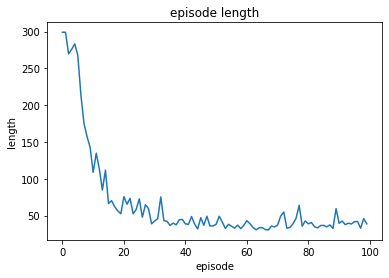

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.mean(endepisodelog,axis= 0))
plt.title("episode length")
plt.xlabel("episode")
plt.ylabel("length")
plt.show()

In [ ]:
plt.plot(np.mean(endepisodelog,axis= 0))
plt.title("mean )
plt.xlabel("episode")
plt.ylabel("length")
plt.show()

In [ ]:
env = MultiGoalArm(False, "reach_goal_avoide_obstacle")
for i in range(300):
    obs, reward, done, info = env.step(np.array([0.8,-1*i/100+0.7,0.1,np.random.uniform(0,0.2)]))
    env.render()
    print(reward)
env.vid.close()

-1.1422134259609222
-1.1232955512412965
-1.1093747191345897
-1.0988243566493356
-1.0904569985533141
-1.084288556521983
-1.0796498613039607
-1.0759986782661428
-1.0729696226477723
-1.0703370053278702
-1.0679652328652196
-1.065771812486701
-1.0637036064420045
-1.0617229211317873
-1.0597999050742377
-1.0579084746720597
-1.0560247810543681
-1.054126547313105
-1.052193034649554
-1.0502051959696117
-1.0481458481825485
-1.0459997801185754
-1.0437537786913325
-1.0413965777278913
-1.038918747096548
-1.0363125472597037
-1.0335717603250811
-1.030691515690982
-1.0276681175490459
-1.0244988827998434
-1.0211819909682252
-1.0177163495384263
-1.0141014752699964
-1.0103373894978875
-1.0064245282842994
-1.0023636646678848
-0.998155843185783
-0.993802323997721
-0.9893045363118519
-0.9846640396715405
-0.9798824916985164
-0.9749616224356032
-0.9699032119409225
-0.9647090735967891
-0.9593810408643256
-0.9539209567526714
-0.9483306659599171
-0.94261200937963
-0.9367668203130771
-0.9307969221478113
-0.9247041

In [ ]:
from base64 import b64encode
from IPython.display import HTML
mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

In [ ]:
env = MultiGoalArm(False, "pick_box_place_to_goal")
for i in range(10):
    obs, reward, done, info = env.step(np.array([0,0,0.17,1]))
    env.render()
    print(reward)
for i in range(100):
    obs, reward, done, info = env.step(np.array([0.7,0.7,0.17,1]))
    env.render()
    print(reward)
for i in range(10):
    obs, reward, done, info = env.step(np.array([0.7,0.7,0.17,-1]))
    env.render()
    print(reward)
for i in range(100):
    obs, reward, done, info = env.step(np.array([0,0,0.3,0]))
    env.render()
    print(reward)
env.vid.close()

-10.928083925972649
-10.944604227060825
-10.946556217468453
-10.94813080308185
-10.949551783303754
-10.950836977580096
-10.95200212652312
-10.953062372410546
-10.954034970722446
-10.954934576750086
-10.935254315781494
-10.91346306192721
-10.888197523473085
-10.85962057477765
-10.828123172375408
-10.794312833720486
-10.759132791306085
-10.723413094112267
-10.687738775958277
-10.652506811082826
-10.617991322574685
-10.584387398343749
-10.551836690430752
-10.520441727297232
-10.490274309968486
-10.461381055748532
-10.433787634301225
-10.407502254481265
-10.382518929203046
-10.358820078425023
-10.336378917454976
-10.315161538370099
-10.295128671802212
-10.276237173538028
-10.258441269898851
-10.24169357660043
-10.225945940615647
-10.211150119404316
-10.197258320800477
-10.184223628928219
-10.172000330634638
-10.160544165836573
-10.149812500389245
-10.13976445453799
-10.130360981820782
-10.12156491331581
-10.113340972749533
-10.1056506319605
-10.098470542446709
-10.09176825434828
-10.085515

In [ ]:
from base64 import b64encode
from IPython.display import HTML
mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

In [ ]:
env = MultiGoalArm(False, "push_box")
for i in range(300):
    obs, reward, done, info = env.step(np.array([0.8,-1*i/100+0.7,0.01,np.random.uniform(0,0.2)]))
    env.render()
    print(reward)
env.vid.close()

-1.4798390897624296
-1.4496857256684599
-1.4203011086755448
-1.3948091721511298
-1.3688786250700564
-1.3440951107669172
-1.3205295878635184
-1.2981587250233035
-1.2769528784599649
-1.2569022518428439
-1.2380097514780262
-1.2202801403532135
-1.2037108142729058
-1.1882862311173614
-1.1739756102174095
-1.1607333405999565
-1.1485009575898621
-1.1372100514892423
-1.1267854507776025
-1.1171482679483442
-1.1082185688529989
-1.0999175546812436
-1.0921692320159861
-1.0849016077966507
-1.0780474739371886
-1.0715448479905114
-1.0653371545988537
-1.0593732041045592
-1.0536070269373177
-1.0479976096852923
-1.0425085701540024
-1.0371077988758848
-1.031767085905055
-1.026461752301414
-1.0211702934498796
-1.0158740414755427
-1.0105568509152838
-1.0052048104381814
-0.9998059803482588
-0.9943501551764427
-0.9888286530399554
-0.9832341248775345
-0.9775603876949306
-0.9718022761130769
-0.9659555126815322
-0.9600165934306921
-0.9539826884479348
-0.9478515546274268
-0.9416214597949364
-0.9352911173149157
-0

In [ ]:
from base64 import b64encode
from IPython.display import HTML
mp4 = open('vid.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)